Epoch: 1, D loss: 0.6935490369796753, G loss: 0.6935304999351501
Epoch: 2, D loss: 0.6931646466255188, G loss: 0.6931639909744263
Epoch: 3, D loss: 0.6931473016738892, G loss: 0.6931474208831787
Epoch: 4, D loss: 0.6931471228599548, G loss: 0.6931471228599548
Epoch: 5, D loss: 0.6931471228599548, G loss: 0.6931471228599548
Epoch: 6, D loss: 0.6931471228599548, G loss: 0.6931473016738892
Epoch: 7, D loss: 0.6931471228599548, G loss: 0.6931471228599548
Epoch: 8, D loss: 0.6931471228599548, G loss: 0.6931471228599548
Epoch: 9, D loss: 0.6931471228599548, G loss: 0.6931471228599548
Epoch: 10, D loss: 0.6931471228599548, G loss: 0.6931471228599548


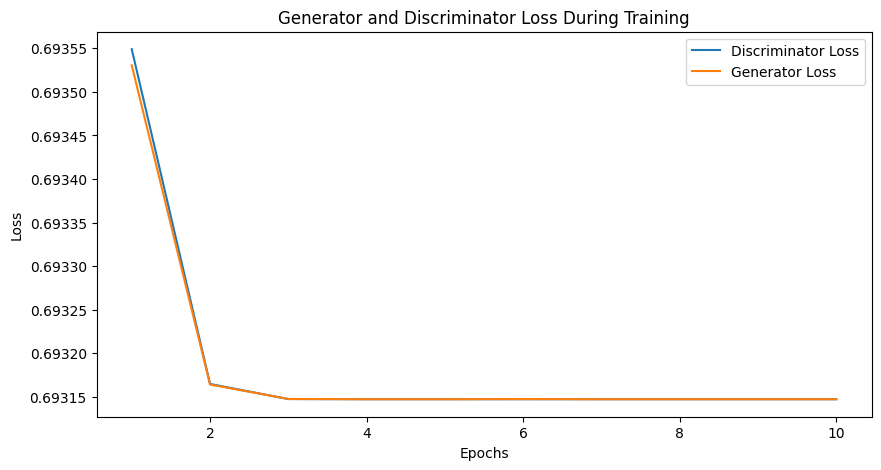

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

# Define the generator
def build_generator(z_size=200, gen_filters=[512, 256, 128, 64, 1], gen_kernel_sizes=[4, 4, 4, 4, 4], gen_strides=[1, 2, 2, 2, 2]):
    input_layer = Input(shape=(1, 1, 1, z_size))
    x = input_layer
    for i, (filter, kernel_size, stride) in enumerate(zip(gen_filters, gen_kernel_sizes, gen_strides)):
        if i == 0:  # First layer does not use padding='same'
            x = layers.Conv3DTranspose(filters=filter, kernel_size=kernel_size, strides=stride)(x)
        else:
            x = layers.Conv3DTranspose(filters=filter, kernel_size=kernel_size, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        if i < len(gen_filters) - 1:  # Last layer uses a sigmoid activation
            x = layers.ReLU()(x)
        else:
            x = layers.Activation('sigmoid')(x)
    model = Model(inputs=input_layer, outputs=x, name="generator")
    return model

# Define the discriminator
def build_discriminator(dis_input_shape=(64, 64, 64, 1), dis_filters=[64, 128, 256, 512, 1], dis_kernel_sizes=[4, 4, 4, 4, 4], dis_strides=[2, 2, 2, 2, 1], dis_paddings=['same', 'same', 'same', 'same', 'valid']):
    input_layer = Input(shape=dis_input_shape)
    x = input_layer
    for filter, kernel_size, stride, padding in zip(dis_filters, dis_kernel_sizes, dis_strides, dis_paddings):
        x = layers.Conv3D(filters=filter, kernel_size=kernel_size, strides=stride, padding=padding)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=x, name="discriminator")
    return model

# Custom training step with manual loss reduction and TensorBoard logging
def train_step(generator, discriminator, batch_size, z_size, log_dir, epoch, number_of_batches, batch_index):
    random_latent_vectors = tf.random.normal(shape=(batch_size, 1, 1, 1, z_size))
    real_images = tf.random.normal(shape=(batch_size, 64, 64, 64, 1))  # Placeholder
    labels_real = tf.ones((batch_size, 1))
    labels_fake = tf.zeros((batch_size, 1))

    # Discriminator training
    with tf.GradientTape() as tape:
        predictions_real = discriminator(real_images, training=True)
        generated_images = generator(random_latent_vectors, training=True)
        predictions_fake = discriminator(generated_images, training=True)
        d_loss_real = tf.keras.losses.binary_crossentropy(labels_real, predictions_real)
        d_loss_fake = tf.keras.losses.binary_crossentropy(labels_fake, predictions_fake)
        d_loss = tf.reduce_mean((d_loss_real + d_loss_fake) / 2)  # Manual loss reduction
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    discriminator.optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    # Generator training
    with tf.GradientTape() as tape:
        generated_images = generator(random_latent_vectors, training=True)
        predictions = discriminator(generated_images, training=True)
        g_loss = tf.keras.losses.binary_crossentropy(labels_real, predictions)
        g_loss = tf.reduce_mean(g_loss)  # Manual loss reduction
    grads = tape.gradient(g_loss, generator.trainable_weights)
    generator.optimizer.apply_gradients(zip(grads, generator.trainable_weights))

    # TensorBoard logging
    with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.scalar('Generator loss', g_loss.numpy(), step=epoch * number_of_batches + batch_index)
        tf.summary.scalar('Discriminator loss', d_loss.numpy(), step=epoch * number_of_batches + batch_index)

    return d_loss, g_loss

# TensorBoard setup
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Model configuration
generator = build_generator()
discriminator = build_discriminator()
generator_optimizer = Adam(lr=0.0025, beta_1=0.5)
discriminator_optimizer = Adam(lr=10e-5, beta_1=0.5)
generator.compile(optimizer=generator_optimizer, loss='binary_crossentropy')
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

batch_size = 32
z_size = 200
epochs = 10
number_of_batches = 100  # Adjust based on your dataset size

# Initialize lists to store loss values
discriminator_losses = []
generator_losses = []

# Training loop with TensorBoard logging
for epoch in range(epochs):
    epoch_d_losses = []
    epoch_g_losses = []
    for batch_index in range(number_of_batches):
        d_loss, g_loss = train_step(generator, discriminator, batch_size, z_size, log_dir, epoch, number_of_batches, batch_index)
        epoch_d_losses.append(d_loss.numpy())
        epoch_g_losses.append(g_loss.numpy())
    # Calculate average loss for the epoch
    avg_d_loss = np.mean(epoch_d_losses)
    avg_g_loss = np.mean(epoch_g_losses)
    discriminator_losses.append(avg_d_loss)
    generator_losses.append(avg_g_loss)
    print(f"Epoch: {epoch + 1}, D loss: {avg_d_loss}, G loss: {avg_g_loss}")

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), discriminator_losses, label='Discriminator Loss')
plt.plot(range(1, epochs + 1), generator_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss During Training')
plt.legend()
plt.show()
